# Preprocessing — C-MAPSS FD001

This notebook prepares the FD001 subset:
- loads raw text files,
- selects sensors (`s01,s05,s10,s16,s18,s19` dropped),
- standardizes features (fit on **training normals only**),
- creates sliding windows (seq_len=80, stride=1, anomaly_horizon=30),
- writes deterministic splits and metadata into `artifacts/`.

All parameters come from `config.yaml`.


## Importing required Libraries

In [1]:
import os, random
os.environ.setdefault("PYTHONHASHSEED", "42")
os.environ.setdefault("TF_DETERMINISTIC_OPS", "1")
os.environ.setdefault("TF_CUDNN_DETERMINISTIC", "1")

import yaml, json, pickle, hashlib
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,4)

import tensorflow as tf


## Setup & Config
- Read `config.yaml`
- Set seeds for reproducibility
- Sanity-check config vs metadata (if re-running)


In [2]:
with open("config.yaml", "r", encoding="utf-8") as f:
    CFG = yaml.safe_load(f)

def yaml_md5(path="config.yaml"):
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

CFG_HASH = yaml_md5("config.yaml")

def require(path):
    cur = CFG
    for k in path.split("."):
        if not isinstance(cur, dict) or k not in cur:
            raise KeyError(f"Missing '{path}' in config.yaml")
        cur = cur[k]
    return cur

DATA_DIR   = Path(require("data.path"))
FEATURES   = require("data.features")     
SEQ_LEN    = int(require("data.seq_len"))
STRIDE     = int(require("data.stride"))
LABEL_MODE = str(require("data.label_mode"))
DILATION   = int(require("data.label_dilation"))
HORIZON    = int(require("data.anomaly_horizon"))
SCALE      = str(require("data.scale")).lower() 
SCALE_FIT  = str(require("data.scale_fit_on"))
LV_THRESH  = float(require("data.drop_low_variance_threshold"))
DROP_SENS  = [str(s) for s in CFG["data"].get("drop_sensors", [])]
UNITWISE   = bool(CFG["data"].get("unitwise", True))

TRAIN_FRAC = float(require("splits.train_frac"))
SPLIT_SEED = int(require("splits.seed"))

SEED       = int(require("repro.seed"))
TF_DET     = bool(CFG["repro"].get("tf_deterministic", True))


ARTIFACTS_DIR = Path("artifacts"); ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
CMAPSS_COLS = ["unit","cycle","os1","os2","os3"] + [f"s{i:02d}" for i in range(1,22)]

print("Config loaded. Key settings:")
print(f"  data path:            {DATA_DIR}")
print(f"  seq_len/stride:       {SEQ_LEN}/{STRIDE}")
print(f"  horizon/dilation:     {HORIZON}/{DILATION}  | label_mode: {LABEL_MODE}")
print(f"  scale:                {SCALE} (fit_on={SCALE_FIT})")
print(f"  drop_low_var_thresh:  {LV_THRESH}")
print(f"  drop_sensors:         {DROP_SENS}")
print(f"  unitwise:             {UNITWISE}")
print(f"  splits:               train_frac={TRAIN_FRAC}, seed={SPLIT_SEED}")
print(f"  repro:                seed={SEED}, tf_deterministic={TF_DET}")
print(f"  yaml_hash:            {CFG_HASH}")


(ARTIFACTS_DIR / "config_snapshot.yaml").write_text(yaml.dump(CFG, sort_keys=False))
(ARTIFACTS_DIR / "yaml_hash.txt").write_text(CFG_HASH + "\n")


Config loaded. Key settings:
  data path:            data
  seq_len/stride:       80/1
  horizon/dilation:     30/3  | label_mode: any
  scale:                standard (fit_on=train_normals_only)
  drop_low_var_thresh:  1e-06
  drop_sensors:         ['s01', 's05', 's10', 's16', 's18', 's19']
  unitwise:             True
  splits:               train_frac=0.8, seed=42
  repro:                seed=42, tf_deterministic=True
  yaml_hash:            2cff7a8dedc0d73ce80e4174ffe62008


33

In [3]:

random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
if TF_DET:
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
print(f"Seeds set: {SEED} | TF deterministic: {TF_DET}")


Seeds set: 42 | TF deterministic: True


##  Load Raw Data (FD001)
- Parse NASA files into a DataFrame
- Assign column names per spec
- Basic sanity checks (rows, engines, sensors)


In [4]:
def load_fd001(data_path: Path):
    tr = pd.read_csv(data_path / "train_FD001.txt", sep=r"\s+", header=None, engine="python")
    te = pd.read_csv(data_path / "test_FD001.txt",  sep=r"\s+", header=None, engine="python")
    tr.columns = CMAPSS_COLS; te.columns = CMAPSS_COLS

    for c in ["unit","cycle"]:
        tr[c] = tr[c].astype(np.int32, copy=False)
        te[c] = te[c].astype(np.int32, copy=False)
    for c in [x for x in tr.columns if x not in ["unit","cycle"]]:
        tr[c] = tr[c].astype(np.float32, copy=False)
        te[c] = te[c].astype(np.float32, copy=False)
    return tr, te

def dilate_binary_labels(labels: np.ndarray, dilation: int) -> np.ndarray:
    if dilation <= 0: return labels.astype(np.int8, copy=False)
    out = labels.astype(np.int8, copy=True)
    ones = np.flatnonzero(out == 1)
    for i in ones:
        s = max(0, i - dilation); e = min(len(out), i + dilation + 1)
        out[s:e] = 1
    return out

def add_rul_and_label_train(df: pd.DataFrame, tau: int, dilation: int) -> pd.DataFrame:
    out = []
    for _, g in df.groupby("unit", sort=False):
        g = g.sort_values("cycle").copy()
        max_c = int(g["cycle"].max())
        g["RUL"] = (max_c - g["cycle"]).astype(np.int32)
        y = (g["RUL"] <= tau).astype(np.int8).to_numpy()
        g["anomaly"] = dilate_binary_labels(y, dilation)
        out.append(g)
    return pd.concat(out, axis=0)


In [5]:
train_raw, test_raw = load_fd001(DATA_DIR)

assert LABEL_MODE == "any", "This preprocessing expects label_mode=any."

train_df_all = add_rul_and_label_train(train_raw, tau=HORIZON, dilation=DILATION)
print(f"[TRAIN] Labeled with horizon={HORIZON}, dilation={DILATION} | rows={len(train_df_all)}")
print(train_df_all.head(3).to_string(index=False))

rul_path = DATA_DIR / "RUL_FD001.txt"
rul_end = pd.read_csv(rul_path, sep=r"\s+", header=None, names=["RUL_end"], engine="python")
rul_end["unit"] = np.arange(1, len(rul_end) + 1, dtype=np.int32)

def add_rul_and_label_test(test_df: pd.DataFrame, rul_end_df: pd.DataFrame, tau: int, dilation: int) -> pd.DataFrame:
    out = []
    for uid, g in test_df.groupby("unit", sort=False):
        g = g.sort_values("cycle").copy()
        max_c = int(g["cycle"].max())
        row = rul_end_df.loc[rul_end_df["unit"] == uid, "RUL_end"]
        if row.empty:
            raise ValueError(f"No RUL entry for test unit {uid} in {rul_path.name}")
        re = int(row.iloc[0])
        g["RUL"] = (re + (max_c - g["cycle"])).astype(np.int32)
        y = (g["RUL"] <= tau).astype(np.int8).to_numpy()
        g["anomaly"] = dilate_binary_labels(y, dilation)
        out.append(g)
    return pd.concat(out, axis=0)

test_df_all = add_rul_and_label_test(test_raw, rul_end, tau=HORIZON, dilation=DILATION)

print(f"[TEST] shape={test_df_all.shape} | units={test_df_all['unit'].nunique()} | "
      f"anomaly points={int(test_df_all['anomaly'].sum())} ({test_df_all['anomaly'].mean():.2%})")


[TRAIN] Labeled with horizon=30, dilation=3 | rows=20631
 unit  cycle     os1     os2   os3        s01        s02         s03         s04   s05       s06        s07         s08         s09  s10       s11        s12         s13         s14    s15  s16   s17    s18   s19       s20       s21  RUL  anomaly
    1      1 -0.0007 -0.0004 100.0 518.669983 641.820007 1589.699951 1400.599976 14.62 21.610001 554.359985 2388.060059 9046.190430  1.3 47.470001 521.659973 2388.020020 8138.620117 8.4195 0.03 392.0 2388.0 100.0 39.060001 23.419001  191        0
    1      2  0.0019 -0.0003 100.0 518.669983 642.150024 1591.819946 1403.140015 14.62 21.610001 553.750000 2388.040039 9044.070312  1.3 47.490002 522.280029 2388.070068 8131.490234 8.4318 0.03 392.0 2388.0 100.0 39.000000 23.423599  190        0
    1      3 -0.0043  0.0003 100.0 518.669983 642.349976 1587.989990 1404.199951 14.62 21.610001 554.260010 2388.080078 9052.940430  1.3 47.270000 522.419983 2388.030029 8133.229980 8.4178 0.03 390.0 23

##  Sensor Selection & Scaling
- Drop low-variance and listed sensors
- Standardize with Z-score using **training normals**
- Persist scaler and selection info to metadata


In [6]:
def engine_split(df: pd.DataFrame, frac: float, seed: int):
    rng = np.random.default_rng(seed)
    engines = df["unit"].unique()
    rng.shuffle(engines)
    n_train = max(1, int(len(engines) * frac))
    return engines[:n_train].tolist(), engines[n_train:].tolist()

def drop_low_variance(df: pd.DataFrame, threshold: float, protect=("unit","cycle","RUL","anomaly")):
    numeric = df.select_dtypes(include=[np.number]).copy()
    numeric.drop(columns=[c for c in protect if c in numeric.columns], inplace=True, errors="ignore")
    var = numeric.var().fillna(0.0)
    to_drop = var[var <= threshold].index.tolist()
    return df.drop(columns=to_drop, errors="ignore"), to_drop

def zero_pad_sensor(name: str):
    if isinstance(name, str) and name.startswith("s") and name[1:].isdigit():
        return f"s{int(name[1:]):02d}"
    return name

train_ids, val_ids = engine_split(train_df_all, TRAIN_FRAC, SPLIT_SEED)
assert len(train_ids) and len(val_ids), "Split resulted in empty train/val; adjust splits.train_frac/seed."

train_df = train_df_all[train_df_all["unit"].isin(train_ids)].copy()
val_df   = train_df_all[train_df_all["unit"].isin(val_ids)].copy()


train_df, dropped_by_var = drop_low_variance(train_df, LV_THRESH)


if isinstance(FEATURES, list):
    feature_cols = [zero_pad_sensor(c) for c in FEATURES]
else:
    mode = str(FEATURES).lower()
    if mode == "sensors_only":
        feature_cols = [c for c in train_df.columns if c.startswith("s")]
    elif mode == "sensors_plus_os":
        feature_cols = [c for c in train_df.columns if c.startswith("s") or c.startswith("os")]
    else:
        raise ValueError("data.features must be 'sensors_only', 'sensors_plus_os', or a list of column names.")


cfg_drop = [zero_pad_sensor(s) for s in DROP_SENS]
feature_cols = [c for c in feature_cols if c not in cfg_drop]


val_df  = val_df.drop(columns=dropped_by_var + cfg_drop, errors="ignore")

print("Dropped by variance:", dropped_by_var)
print("Dropped fixed (config):", cfg_drop)
print(f"Using {len(feature_cols)} features; first 10:", feature_cols[:10])
assert feature_cols, "No features left after drops; check config."


Dropped by variance: ['os2', 'os3', 's01', 's05', 's10', 's16', 's18', 's19']
Dropped fixed (config): ['s01', 's05', 's10', 's16', 's18', 's19']
Using 15 features; first 10: ['s02', 's03', 's04', 's06', 's07', 's08', 's09', 's11', 's12', 's13']


In [7]:
test_df = test_df_all.drop(columns=dropped_by_var + cfg_drop, errors="ignore")
keep_test = [c for c in (feature_cols + ["unit","cycle","anomaly","RUL"]) if c in test_df.columns]
test_df = test_df[keep_test].copy()

missing_feats = [c for c in feature_cols if c not in test_df.columns]
if missing_feats:
    raise ValueError(f"[TEST] Missing features after alignment: {missing_feats}")
print("[TEST] After alignment:", test_df.shape)


assert SCALE_FIT == "train_normals_only", "config expects scale_fit_on=train_normals_only"
normal_train = train_df[train_df["anomaly"] == 0]

if SCALE == "standard":
    scaler = StandardScaler()
elif SCALE == "minmax":
    scaler = MinMaxScaler()
else:
    raise ValueError("data.scale must be 'standard' or 'minmax'.")

scaler.fit(normal_train[feature_cols].values)

for df_ in (train_df, val_df, test_df):
    df_.loc[:, feature_cols] = scaler.transform(df_[feature_cols].values)


for nm, df_ in [("train", train_df), ("val", val_df), ("test", test_df)]:
    x = df_[feature_cols].values
    assert np.isfinite(x).all(), f"{nm}: found NaN/Inf after scaling."

print(f"Scaling: {SCALE} | fit rows (normal train): {len(normal_train)}")


[TEST] After alignment: (13096, 19)
Scaling: standard | fit rows (normal train): 13807


##  Sliding Windows & Labels
- seq_len=80, stride=1
- label_mode=`any` with dilation=3, horizon=30
- Save arrays: `X_train_normal.npy`, `X_val.npy`, `y_val.npy`, `X_test.npy`, `y_test.npy`


In [ ]:
def make_windows(df: pd.DataFrame, feature_cols, seq_len: int, stride: int, label_mode="any"):
    Xs, ys = [], []
    for _, g in df.groupby("unit", sort=False):
        g = g.sort_values("cycle")
        X = g[feature_cols].values
        y = g["anomaly"].values.astype(np.int8)
        for s in range(0, len(g) - seq_len + 1, stride):
            e = s + seq_len
            if label_mode == "any":
                lw = int(y[s:e].max())
            elif label_mode == "center":
                lw = int(y[s:e][len(y[s:e])//2])
            else:
                raise ValueError("label_mode must be 'any' or 'center'")
            Xs.append(X[s:e]); ys.append(lw)
    return np.stack(Xs).astype(np.float32), np.array(ys, dtype=np.int8)

def make_windows_with_ids(df: pd.DataFrame, feature_cols, seq_len: int, stride: int, label_mode="any"):
    Xs, ys, ids = [], [], []
    for uid, g in df.groupby("unit", sort=False):
        g = g.sort_values("cycle")
        X = g[feature_cols].values
        y = g["anomaly"].values.astype(np.int8)
        for s in range(0, len(g) - seq_len + 1, stride):
            e = s + seq_len
            if label_mode == "any":
                lw = int(y[s:e].max())
            elif label_mode == "center":
                lw = int(y[s:e][len(y[s:e])//2])
            else:
                raise ValueError("label_mode must be 'any' or 'center'")
            Xs.append(X[s:e]); ys.append(lw); ids.append(int(uid))
    return (
        np.stack(Xs).astype(np.float32),
        np.array(ys, dtype=np.int8),
        np.array(ids, dtype=np.int32),
    )

X_train, y_train = make_windows(train_df, feature_cols, SEQ_LEN, STRIDE, LABEL_MODE)
X_train_normal = X_train[y_train == 0]


X_val,  y_val,  ids_val  = make_windows_with_ids(val_df,  feature_cols, SEQ_LEN, STRIDE, LABEL_MODE)
X_test, y_test, ids_test = make_windows_with_ids(test_df, feature_cols, SEQ_LEN, STRIDE, LABEL_MODE)

print("Train windows :", X_train.shape, "→ normal only:", X_train_normal.shape)
print("Val windows   :", X_val.shape,   "| anomaly rate:", float(y_val.mean()))
print("Test windows  :", X_test.shape,  "| anomaly rate:", float(y_test.mean()))


np.save(ARTIFACTS_DIR / "X_train_normal.npy", X_train_normal)
np.save(ARTIFACTS_DIR / "X_val.npy",           X_val)
np.save(ARTIFACTS_DIR / "y_val.npy",           y_val.astype(np.int32))
np.save(ARTIFACTS_DIR / "X_test.npy",          X_test)
np.save(ARTIFACTS_DIR / "y_test.npy",          y_test.astype(np.int32))


np.save(ARTIFACTS_DIR / "unit_ids_val.npy",    ids_val)
np.save(ARTIFACTS_DIR / "unit_ids_test.npy",   ids_test)

Train windows : (10207, 80, 15) → normal only: (7487, 80, 15)
Val windows   : (2524, 80, 15) | anomaly rate: 0.2694136291600634
Test windows  : (5660, 80, 15) | anomaly rate: 0.07190812720848057


##  Deterministic Splits & Metadata
- Write `splits.json` (indices)
- Write `preprocessing_meta.json` (sensors, seq_len, stride, scale, dropped sensors, yaml hash)


Feature order hash: 2f790daa
Split hash: be148b03


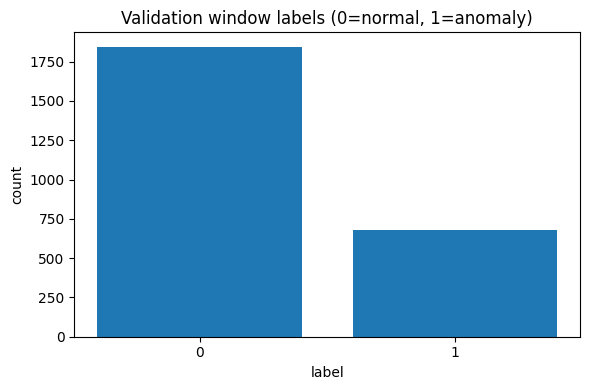

Saved plot: artifacts\val_label_hist.png
{
  "train_windows_total": 10207,
  "train_windows_normal": 7487,
  "val_windows_total": 2524,
  "val_anomaly_rate": 0.2694136291600634,
  "test_windows_total": 5660,
  "test_anomaly_rate": 0.07190812720848057,
  "val_unit_ids_saved": 2524,
  "test_unit_ids_saved": 5660
}
Artifacts saved: ['README.txt', 'X_test.npy', 'X_train_normal.npy', 'X_val.npy', 'config_snapshot.yaml', 'data_report.json', 'feat_mad_abs.npy', 'feat_med_abs.npy', 'feat_var_lstm.npy', 'lstm_ae_best.weights.h5', 'lstm_ae_final.weights.h5', 'manifest.json', 'metrics_lstm_mad_warmup.json', 'metrics_lstm_test.json', 'metrics_lstm_val.json', 'metrics_lstm_varnorm_calibrated.json', 'pr_lstm_test.npy', 'pr_lstm_val.npy', 'preprocessing_meta.json', 'scaler.pkl', 'scores_lstm_test.npy', 'scores_lstm_test_mad.npy', 'scores_lstm_test_mad_warmup.npy', 'scores_lstm_test_varnorm_warmup.npy', 'scores_lstm_test_varnorm_warmup_ema.npy', 'scores_lstm_val.npy', 'scores_lstm_val_mad.npy', 'score

In [ ]:
feature_order_hash = hashlib.md5(",".join(feature_cols).encode()).hexdigest()[:8]

split_hash = hashlib.md5((
    ",".join(map(str, map(int, train_ids))) + "|" +
    ",".join(map(str, map(int, val_ids)))
).encode()).hexdigest()[:8]

print("Feature order hash:", feature_order_hash)
print("Split hash:", split_hash)

preprocessing_meta = {
    "yaml_hash": CFG_HASH,
    "seed": SEED,
    "seq_len": SEQ_LEN, "stride": STRIDE,
    "label_mode": LABEL_MODE,
    "label_dilation": DILATION,
    "anomaly_horizon": HORIZON,
    "scale": {"type": SCALE},
    "scale_fit_on": SCALE_FIT,
    "drop_low_variance_threshold": LV_THRESH,
    "features_used": feature_cols,
    "features_hash": feature_order_hash,
    "dropped_by_var": dropped_by_var,
    "dropped_fixed": cfg_drop,
    "n_features": int(len(feature_cols)),
    "split_hash": split_hash,
    "has_unit_ids": True,
}
(ARTIFACTS_DIR / "preprocessing_meta.json").write_text(json.dumps(preprocessing_meta, indent=2))

report = {
    "train_windows_total": int(len(X_train)),
    "train_windows_normal": int(len(X_train_normal)),
    "val_windows_total": int(len(X_val)),
    "val_anomaly_rate": float(y_val.mean()),
    "test_windows_total": int(len(X_test)),
    "test_anomaly_rate": float(y_test.mean()),
    "val_unit_ids_saved": int(len(ids_val)),
    "test_unit_ids_saved": int(len(ids_test)),
}
(ARTIFACTS_DIR / "data_report.json").write_text(json.dumps(report, indent=2))

manifest = {
    "yaml_hash": CFG_HASH,
    "arrays": {
        "X_train_normal": list(X_train_normal.shape),
        "X_val":          list(X_val.shape),
        "X_test":         list(X_test.shape),
    },
    "labels": {
        "y_val_total": int(len(y_val)), "y_val_pos": int(y_val.sum()),
        "y_test_total": int(len(y_test)), "y_test_pos": int(y_test.sum()),
    },
    "meta": {
        "seq_len": SEQ_LEN, "stride": STRIDE,
        "n_features": int(len(feature_cols)),
        "scale": SCALE,
        "label_dilation": DILATION,
        "anomaly_horizon": HORIZON,
        "dropped_fixed": cfg_drop,
        "unit_ids_files": ["unit_ids_val.npy", "unit_ids_test.npy"],
    },
}
(ARTIFACTS_DIR / "manifest.json").write_text(json.dumps(manifest, indent=2))


try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic("matplotlib", "inline")
except Exception:
    pass

import matplotlib.pyplot as plt
plt.figure()
plt.hist(y_val, bins=[-0.5,0.5,1.5], rwidth=0.8)
plt.xticks([0,1])
plt.title("Validation window labels (0=normal, 1=anomaly)")
plt.xlabel("label"); plt.ylabel("count")
plt.tight_layout()
out_png = ARTIFACTS_DIR / "val_label_hist.png"
plt.savefig(out_png, dpi=150)
plt.show(); plt.close()
print("Saved plot:", out_png)
print(json.dumps(report, indent=2))
print("Artifacts saved:", sorted(p.name for p in ARTIFACTS_DIR.iterdir()))
